In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from collections import Counter
from model import MarginLoss, make_model
from torch.optim import lr_scheduler
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [2]:
# Define the transfer learning dataset
data_path = 'numbers'

transfer_target_dataset = datasets.ImageFolder(
    root=data_path,
    transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Pad(2),
        transforms.RandomCrop((28, 28)),
        transforms.ToTensor(),
]))

class_mapping = transfer_target_dataset.class_to_idx
class_mapping

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8}

In [3]:
# Split data to test and train
# Use 80% to train
train_size = int(0.8 * len(transfer_target_dataset))
test_size = len(transfer_target_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(transfer_target_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))

print('Train size: ', len(train_dataset))
print('Test size: ', len(test_dataset))

Train size:  12780
Test size:  3195


In [4]:
# Label distribution
train_classes = [label for _, label in transfer_target_dataset]
Counter(train_classes)

Counter({0: 1761,
         1: 1743,
         2: 1801,
         3: 1741,
         4: 1847,
         5: 1781,
         6: 1779,
         7: 1777,
         8: 1745})

In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

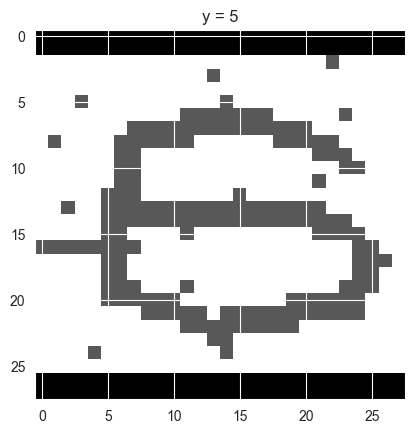

In [6]:
# Check a sample
sample = next(iter(train_loader))

plt.imshow(sample[0][0].reshape(28, 28), cmap='gray')
plt.title('y = {}'.format(sample[1][0]))
plt.show()

In [7]:
model = make_model()
model.load_state_dict(torch.load('checkpoints/019_model_dict_reconstructionTrue.pth')['model_state_dict'])

model.train()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

EfficientCapsNetWithReconstruction(
  (efficient_capsnet): EfficientCapsNet(
    (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
    (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (primary_caps): PrimaryCapsLayer(
      (depthwise_conv): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
    )
    (digit_caps): RoutingLayer()
  )
  (reconstruction_net): Recons

In [8]:
args = {
    "batch_size": 64,
    "test_batch_size": 64,
    "epochs": 50,
    "lr": 5e-4,
    "reconstruction_alpha": 0.0005,
}

optimizer = optim.Adam(model.parameters(), lr=args["lr"])

scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, verbose=True, factor=0.9, patience=4, min_lr=1e-5, mode="max"
)

loss_fn = MarginLoss(0.9, 0.1, 0.5)

In [9]:
confusion_mat = np.zeros((9, 9), dtype=int)
max_test_accuracy = 0

def train(current_epoch):
    model.train()
    # 將train_loader包裝在tqdm進度條中
    train_loader_tqdm = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Train Epoch: {current_epoch}')
    for batch_idx, (data, target) in train_loader_tqdm:
        data, target = data.to(device), target.to(device)
        
        data, target = Variable(data), Variable(target, requires_grad=False)
        optimizer.zero_grad()
        
        output, probs = model(data)
        reconstruction_loss = F.mse_loss(output, data.view(-1, 784))
        margin_loss = loss_fn(probs, target)
        loss = args["reconstruction_alpha"] * reconstruction_loss + margin_loss
            
        loss.backward()
        optimizer.step()
        
        # 更新tqdm進度條的描述信息
        train_loader_tqdm.set_description(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                current_epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                loss.item(),
            )
        )
            
def test(final=False):
    global confusion_mat, max_test_accuracy
    model.eval()
    test_loss = 0
    correct = 0
    if final:
        confusion_mat = np.zeros((9, 9), dtype=int)
    with tqdm(test_loader, unit="batch", desc="Test Set") as test_loader_tqdm:
        for data, target in test_loader_tqdm:
            data, target = data.to(device), target.to(device)
            data, target = Variable(data), Variable(target)

            output, probs = model(data)
            reconstruction_loss = F.mse_loss(
                output, data.view(-1, 784), reduction='sum'
            ).item()
            test_loss += loss_fn(probs, target, size_average=False).item()
            test_loss += args["reconstruction_alpha"] * reconstruction_loss

            pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            if final:
                for i in range(len(pred)):
                    true_label = target.data[i]
                    pred_label = pred.data[i]
                    confusion_mat[true_label][pred_label] += 1
            test_loader_tqdm.set_postfix(Loss=test_loss / len(test_loader.dataset), Accuracy=100.0 * correct / len(test_loader.dataset))
            
            if 100.0 * correct / len(test_loader.dataset) > max_test_accuracy:
                max_test_accuracy = 100.0 * correct / len(test_loader.dataset)
                torch.save(
                    model.state_dict(),
                    f"checkpoints/{max_test_accuracy:0.2f}_reconstruction_transfer.pth",
                )

    if final:
        sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title("Efficient CapsNet - MNIST Confusion Matrix")
        plt.savefig("confusion_mat-reconstruction.png")
    return test_loss

Train Epoch: 1 [8756/12780 (100%)]	Loss: 0.002834: 100%|██████████| 200/200 [00:14<00:00, 13.85it/s]
Test Set: 100%|██████████| 50/50 [00:02<00:00, 20.29batch/s, Accuracy=tensor(95.0861), Loss=0.0756]
Train Epoch: 2 [8756/12780 (100%)]	Loss: 0.004705: 100%|██████████| 200/200 [00:08<00:00, 24.67it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 35.18batch/s, Accuracy=tensor(98.1221), Loss=0.0469]
Train Epoch: 3 [8756/12780 (100%)]	Loss: 0.002024: 100%|██████████| 200/200 [00:07<00:00, 27.57it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.60batch/s, Accuracy=tensor(99.3740), Loss=0.0355] 
Train Epoch: 4 [8756/12780 (100%)]	Loss: 0.002015: 100%|██████████| 200/200 [00:07<00:00, 27.16it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.98batch/s, Accuracy=tensor(99.3114), Loss=0.0331] 
Train Epoch: 5 [8756/12780 (100%)]	Loss: 0.000292: 100%|██████████| 200/200 [00:07<00:00, 27.69it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.05batch/s, Accuracy=tensor(99.5618), Loss=0

Epoch 00006: reducing learning rate of group 0 to 4.5000e-04.


Train Epoch: 7 [8756/12780 (100%)]	Loss: 0.000276: 100%|██████████| 200/200 [00:07<00:00, 28.21it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.96batch/s, Accuracy=tensor(99.7183), Loss=0.029]  
Train Epoch: 8 [8756/12780 (100%)]	Loss: 0.000334: 100%|██████████| 200/200 [00:07<00:00, 27.87it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.32batch/s, Accuracy=tensor(99.5931), Loss=0.0285] 
Train Epoch: 9 [8756/12780 (100%)]	Loss: 0.000250: 100%|██████████| 200/200 [00:07<00:00, 28.17it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.32batch/s, Accuracy=tensor(99.8748), Loss=0.0275] 
Train Epoch: 10 [8756/12780 (100%)]	Loss: 0.000149: 100%|██████████| 200/200 [00:07<00:00, 28.00it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.53batch/s, Accuracy=tensor(99.7496), Loss=0.0279] 
Train Epoch: 11 [8756/12780 (100%)]	Loss: 0.000495: 100%|██████████| 200/200 [00:07<00:00, 28.05it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.06batch/s, Accuracy=tensor(99.4679), Lo

Epoch 00011: reducing learning rate of group 0 to 4.0500e-04.


Train Epoch: 12 [8756/12780 (100%)]	Loss: 0.000113: 100%|██████████| 200/200 [00:07<00:00, 27.73it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.67batch/s, Accuracy=tensor(99.8435), Loss=0.0266] 
Train Epoch: 13 [8756/12780 (100%)]	Loss: 0.000040: 100%|██████████| 200/200 [00:07<00:00, 27.91it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.26batch/s, Accuracy=tensor(99.8748), Loss=0.0268] 
Train Epoch: 14 [8756/12780 (100%)]	Loss: 0.000045: 100%|██████████| 200/200 [00:07<00:00, 27.93it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.88batch/s, Accuracy=tensor(99.7183), Loss=0.0272] 
Train Epoch: 15 [8756/12780 (100%)]	Loss: 0.000044: 100%|██████████| 200/200 [00:07<00:00, 27.78it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.44batch/s, Accuracy=tensor(99.8748), Loss=0.0269] 
Train Epoch: 16 [8756/12780 (100%)]	Loss: 0.000291: 100%|██████████| 200/200 [00:07<00:00, 27.80it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.71batch/s, Accuracy=tensor(99.8748),

Epoch 00016: reducing learning rate of group 0 to 3.6450e-04.


Train Epoch: 17 [8756/12780 (100%)]	Loss: 0.000320: 100%|██████████| 200/200 [00:07<00:00, 27.57it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.65batch/s, Accuracy=tensor(99.8748), Loss=0.0269] 
Train Epoch: 18 [8756/12780 (100%)]	Loss: 0.000120: 100%|██████████| 200/200 [00:07<00:00, 27.83it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.52batch/s, Accuracy=tensor(99.8435), Loss=0.0261] 
Train Epoch: 19 [8756/12780 (100%)]	Loss: 0.000042: 100%|██████████| 200/200 [00:07<00:00, 28.03it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.49batch/s, Accuracy=tensor(99.9061), Loss=0.0256] 
Train Epoch: 20 [8756/12780 (100%)]	Loss: 0.000038: 100%|██████████| 200/200 [00:07<00:00, 27.86it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.02batch/s, Accuracy=tensor(99.8122), Loss=0.0261] 
Train Epoch: 21 [8756/12780 (100%)]	Loss: 0.000041: 100%|██████████| 200/200 [00:07<00:00, 27.62it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.91batch/s, Accuracy=tensor(99.8435),

Epoch 00021: reducing learning rate of group 0 to 3.2805e-04.


Train Epoch: 22 [8756/12780 (100%)]	Loss: 0.000184: 100%|██████████| 200/200 [00:07<00:00, 27.98it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.15batch/s, Accuracy=tensor(99.7809), Loss=0.0263] 
Train Epoch: 23 [8756/12780 (100%)]	Loss: 0.000044: 100%|██████████| 200/200 [00:07<00:00, 27.77it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.52batch/s, Accuracy=tensor(99.7809), Loss=0.0262] 
Train Epoch: 24 [8756/12780 (100%)]	Loss: 0.000084: 100%|██████████| 200/200 [00:07<00:00, 27.78it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.54batch/s, Accuracy=tensor(99.9061), Loss=0.025]  
Train Epoch: 25 [8756/12780 (100%)]	Loss: 0.000136: 100%|██████████| 200/200 [00:07<00:00, 27.74it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.24batch/s, Accuracy=tensor(99.8748), Loss=0.0261] 
Train Epoch: 26 [8756/12780 (100%)]	Loss: 0.000087: 100%|██████████| 200/200 [00:07<00:00, 28.10it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.11batch/s, Accuracy=tensor(99.9374),

Epoch 00026: reducing learning rate of group 0 to 2.9525e-04.


Train Epoch: 27 [8756/12780 (100%)]	Loss: 0.000067: 100%|██████████| 200/200 [00:07<00:00, 26.75it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.02batch/s, Accuracy=tensor(99.9374), Loss=0.0251] 
Train Epoch: 28 [8756/12780 (100%)]	Loss: 0.000045: 100%|██████████| 200/200 [00:07<00:00, 28.13it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.51batch/s, Accuracy=tensor(99.8748), Loss=0.0257] 
Train Epoch: 29 [8756/12780 (100%)]	Loss: 0.000063: 100%|██████████| 200/200 [00:07<00:00, 28.05it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.00batch/s, Accuracy=tensor(99.8748), Loss=0.0254] 
Train Epoch: 30 [8756/12780 (100%)]	Loss: 0.000028: 100%|██████████| 200/200 [00:07<00:00, 27.88it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.58batch/s, Accuracy=tensor(99.9687), Loss=0.0249] 
Train Epoch: 31 [8756/12780 (100%)]	Loss: 0.000029: 100%|██████████| 200/200 [00:07<00:00, 27.43it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 38.34batch/s, Accuracy=tensor(99.9374),

Epoch 00031: reducing learning rate of group 0 to 2.6572e-04.


Train Epoch: 32 [8756/12780 (100%)]	Loss: 0.000034: 100%|██████████| 200/200 [00:07<00:00, 27.54it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.75batch/s, Accuracy=tensor(99.8435), Loss=0.0258] 
Train Epoch: 33 [8756/12780 (100%)]	Loss: 0.000040: 100%|██████████| 200/200 [00:07<00:00, 26.81it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.08batch/s, Accuracy=tensor(99.8748), Loss=0.0252] 
Train Epoch: 34 [8756/12780 (100%)]	Loss: 0.000037: 100%|██████████| 200/200 [00:07<00:00, 27.39it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.68batch/s, Accuracy=tensor(100.), Loss=0.0251]    
Train Epoch: 35 [8756/12780 (100%)]	Loss: 0.000044: 100%|██████████| 200/200 [00:07<00:00, 27.88it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.08batch/s, Accuracy=tensor(99.9061), Loss=0.025]  
Train Epoch: 36 [8756/12780 (100%)]	Loss: 0.000055: 100%|██████████| 200/200 [00:07<00:00, 28.00it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.95batch/s, Accuracy=tensor(99.9374),

Epoch 00036: reducing learning rate of group 0 to 2.3915e-04.


Train Epoch: 37 [8756/12780 (100%)]	Loss: 0.000048: 100%|██████████| 200/200 [00:07<00:00, 27.43it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.24batch/s, Accuracy=tensor(99.9374), Loss=0.0247] 
Train Epoch: 38 [8756/12780 (100%)]	Loss: 0.000047: 100%|██████████| 200/200 [00:07<00:00, 28.23it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.42batch/s, Accuracy=tensor(99.8122), Loss=0.0255] 
Train Epoch: 39 [8756/12780 (100%)]	Loss: 0.000054: 100%|██████████| 200/200 [00:07<00:00, 27.84it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.32batch/s, Accuracy=tensor(99.9374), Loss=0.025]  
Train Epoch: 40 [8756/12780 (100%)]	Loss: 0.000031: 100%|██████████| 200/200 [00:07<00:00, 27.67it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 41.26batch/s, Accuracy=tensor(99.9061), Loss=0.0246] 
Train Epoch: 41 [8756/12780 (100%)]	Loss: 0.000131: 100%|██████████| 200/200 [00:07<00:00, 27.84it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.86batch/s, Accuracy=tensor(99.8748),

Epoch 00041: reducing learning rate of group 0 to 2.1523e-04.


Train Epoch: 42 [8756/12780 (100%)]	Loss: 0.000044: 100%|██████████| 200/200 [00:07<00:00, 27.62it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.76batch/s, Accuracy=tensor(99.9374), Loss=0.0248] 
Train Epoch: 43 [8756/12780 (100%)]	Loss: 0.000036: 100%|██████████| 200/200 [00:07<00:00, 27.94it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.71batch/s, Accuracy=tensor(99.9374), Loss=0.0247] 
Train Epoch: 44 [8756/12780 (100%)]	Loss: 0.000131: 100%|██████████| 200/200 [00:07<00:00, 27.87it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.43batch/s, Accuracy=tensor(100.), Loss=0.0245]    
Train Epoch: 45 [8756/12780 (100%)]	Loss: 0.000092: 100%|██████████| 200/200 [00:07<00:00, 27.90it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.75batch/s, Accuracy=tensor(99.8748), Loss=0.0256] 
Train Epoch: 46 [8756/12780 (100%)]	Loss: 0.000048: 100%|██████████| 200/200 [00:07<00:00, 27.85it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.14batch/s, Accuracy=tensor(99.9374),

Epoch 00046: reducing learning rate of group 0 to 1.9371e-04.


Train Epoch: 47 [8756/12780 (100%)]	Loss: 0.000025: 100%|██████████| 200/200 [00:07<00:00, 27.84it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 39.93batch/s, Accuracy=tensor(99.9061), Loss=0.0247] 
Train Epoch: 48 [8756/12780 (100%)]	Loss: 0.000027: 100%|██████████| 200/200 [00:07<00:00, 27.83it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.93batch/s, Accuracy=tensor(99.9687), Loss=0.0247] 
Train Epoch: 49 [8756/12780 (100%)]	Loss: 0.000035: 100%|██████████| 200/200 [00:07<00:00, 27.86it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 40.95batch/s, Accuracy=tensor(99.8748), Loss=0.0248] 
Train Epoch: 50 [8756/12780 (100%)]	Loss: 0.000033: 100%|██████████| 200/200 [00:07<00:00, 28.07it/s]
Test Set: 100%|██████████| 50/50 [00:01<00:00, 36.41batch/s, Accuracy=tensor(99.9687), Loss=0.0244] 



 ---------------------------- Finished Training ---------------------------- 


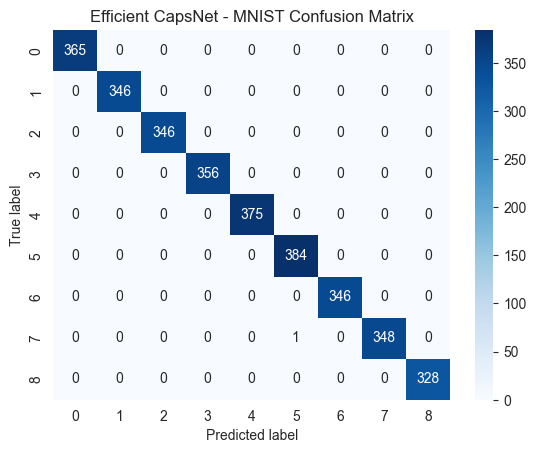

In [10]:
for epoch in range(1, args["epochs"] + 1):
    final = True if epoch == args["epochs"] else False
    train(epoch)
    test_loss = test(final)
    scheduler.step(test_loss)
    if epoch % 10 == 0 or epoch == args["epochs"]:
        # Save the model dict
        torch.save(
            model.state_dict(),
            f"checkpoints/{epoch:03d}_model_dict_reconstruction_transfer.pth",
        )

print("\n", "-" * 28, "Finished Training", "-" * 28, "\n")

In [16]:
# Load the best model
model.load_state_dict(torch.load('checkpoints/99.97_reconstruction_transfer.pth'))

<All keys matched successfully>

In [17]:
# For deployment, we only need the convolutional layers, no need for the decoder
deploy_model = model.efficient_capsnet
deploy_model

EfficientCapsNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=valid)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
  (batch_norm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (primary_caps): PrimaryCapsLayer(
    (depthwise_conv): Conv2d(128, 128, kernel_size=(9, 9), stride=(1, 1), padding=valid, groups=128)
  )
  (digit_caps): RoutingLayer()
)

In [18]:
# Save the model
torch.save(deploy_model.state_dict(), 'checkpoints/efficient_capsnet_deploy.pth')

In [19]:
# Check the model output shape
deploy_model.eval()
sample = next(iter(train_loader))
output, prob = deploy_model(sample[0].to(device))
output.shape

torch.Size([64, 10, 16])

In [20]:
prob.shape

torch.Size([64, 10])